# Create masks for equatorial zonal velocities at all depths to 400m, at all ADCP longitudes
## Depth levels: 1-22 (0-21)
## Longitudes: 170W, 140W, 110W, 165E, 156E, 147E

Note: Daily etc. data have 125W, but the only point is off the equator at 8N

In [38]:
import os
import numpy as np
import xarray as xr
import warnings
import matplotlib.pyplot as plt
from xmitgcm import open_mdsdataset,utils
from MITgcmutils import rdmds, wrmds
import ecco_v4_py as ecco
import pych.ecco as pe

import warnings

In [17]:
llc = pe.read_mds('/workspace/grids/llc90/',iters=None)

/workspace/xmitgcm/xmitgcm/mds_store.py:854: UserWarning: Couldn't find available_diagnostics.log in /workspace/grids/llc90/ or /workspace/grids/llc90/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


In [18]:
mapper = pe.atlantic_map(llc)

In [19]:
grid = ecco.get_llc_grid(llc)

## Get vertical masks to be used for all

There are 22 masks, one for each vertical level. Use each one at each longitude

In [36]:
def get_vertical_mask(index):
    return 1.*(llc.k==index).values

##  170W horizontal mask

In [37]:
maskW = {}
maskS = {}

In [20]:
lon = -170
lat1 = .5
lat2 = -.5

In [40]:
for lon,key in zip([-170,-140,-110,165,156,147],
                   ['170W','140W','110W','165E','156E','147E']):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        maskW[key],maskS[key] = pe.get_euc_masks(ds=llc,pt1=[lon,lat1],pt2=[lon,lat2],grid=grid)
    maskW[key] = .5*maskW[key]
    maskS[key] = .5*maskS[key]
    print(f' --- lon = {lon} ---')
    print('Sum maskW: ',maskW[key].sum().values)
    print('Sum maskS: ',maskS[key].sum().values)

 --- lon = -170 ---
Sum maskW:  0.0
Sum maskS:  1.0
 --- lon = -140 ---
Sum maskW:  0.0
Sum maskS:  1.0
 --- lon = -110 ---
Sum maskW:  0.0
Sum maskS:  1.0
 --- lon = 165 ---
Sum maskW:  0.0
Sum maskS:  1.0
 --- lon = 156 ---
Sum maskW:  0.0
Sum maskS:  1.0
 --- lon = 147 ---
Sum maskW:  0.0
Sum maskS:  1.0


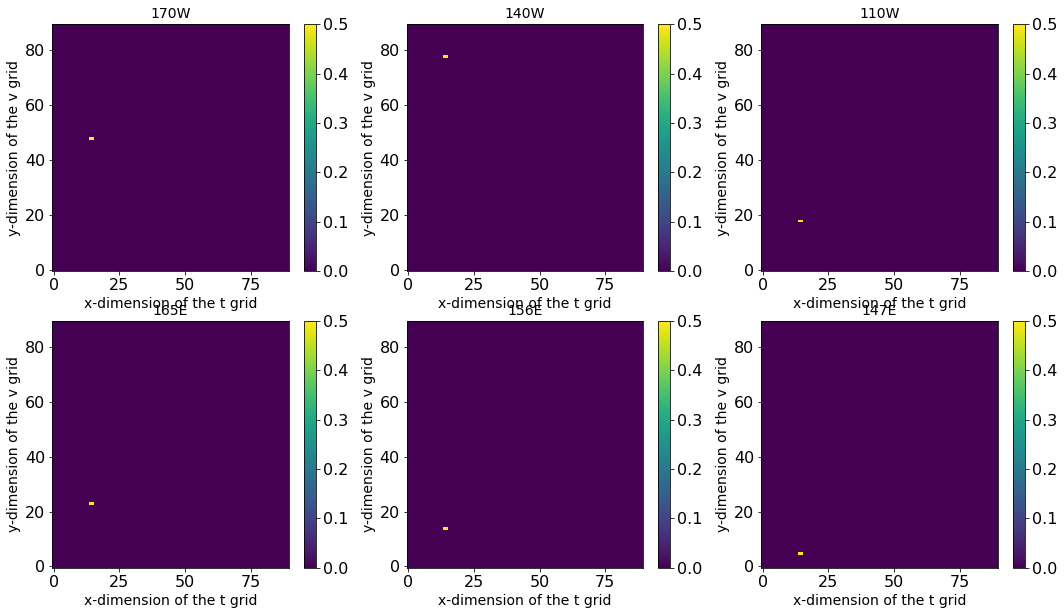

In [45]:
fig,axs = plt.subplots(2,3,figsize=(18,10))
for ax,key in zip(axs.flatten(),maskS.keys()):
    tile = 8 if key != '110W' else 11
    maskS[key].isel(tile=tile).plot(ax=ax)
    ax.set(title=key)

In [21]:
vvelMaskK = uvelMaskK.copy()

In [46]:
6*22

132

## Write them out

In [47]:
mask_dir = 'masks_all_lon'
if not os.path.isdir(mask_dir):
    os.makedirs(mask_dir)

In [49]:
def write_llc_bin(fname,xda):
    if 'tile' in xda.dims:
        xda = xda.rename({'tile':'face'})
        
    extra_metadata = utils.get_extra_metadata(domain='llc', nx=90)
    facets = utils.rebuild_llc_facets(xda, extra_metadata)
    compact = utils.llc_facets_2d_to_compact(facets, extra_metadata)
    utils.write_to_binary(compact, fname)

In [50]:
for key in maskW.keys():
    for k in np.arange(22):
        fnameW = f'{mask_dir}/uvel_{key}_{k:02}k_W'
        fnameS = f'{mask_dir}/uvel_{key}_{k:02}k_S'
        fnameK = f'{mask_dir}/uvel_{key}_{k:02}k_K'
        
        maskK = get_vertical_mask(k)
        
        write_llc_bin(fnameW,maskW[key])
        write_llc_bin(fnameS,maskS[key])
        utils.write_to_binary(maskK.flatten(),fnameK)